<a href="https://colab.research.google.com/github/MhThorq/FraudDet-Optima/blob/main/Fraud_Detect_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# Memanggil data yang sudah disimpan sebelumnya
train = pd.read_pickle('/content/drive/MyDrive/Fraud-Dataset/processed_data.pkl')

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Fraud-Dataset/processed_data.pkl')
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
# 1. Identifikasi kolom berdasarkan tipenya
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns

# 2. Imputasi kolom kategorikal dengan string khusus
df[cat_cols] = df[cat_cols].fillna('MISSING')

# 3. Imputasi kolom numerik dengan nilai di luar jangkauan data (misal -999)
df[num_cols] = df[num_cols].fillna(-999)

# 4. Lanjutkan dengan Label Encoding untuk kolom kategorikal
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    # Tidak perlu astype(str) lagi karena sudah diisi dengan 'MISSING'
    df[col] = le.fit_transform(df[col])

print("Pre-processing selesai: Imputasi dipisahkan antara numerik (-999) dan kategorikal ('MISSING').")

Pre-processing selesai: Imputasi dipisahkan antara numerik (-999) dan kategorikal ('MISSING').


In [ ]:
from sklearn.model_selection import train_test_split
import gc

# Tambahkan baris ini di paling atas Sel 5
df = df.sort_values('TransactionDT').reset_index(drop=True)

# ... (lanjutkan dengan kode sampling Anda yang sudah ada)

# Misal kita ingin mengambil 20% data saja agar RAM aman
# df adalah dataframe gabungan (train) yang sudah Anda buat
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Melakukan stratified sampling
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=0.2,      # Mengambil 20% data
    stratify=y,          # KUNCI: Menjaga rasio label Fraud
    random_state=42
)

# Menggabungkan kembali menjadi satu dataframe sampel
df_sample = pd.concat([X_sample, y_sample], axis=1)

# PENTING: Hapus dataframe lama dan bersihkan RAM
del df, X, y
gc.collect()

print(f"Sampling selesai. Ukuran data baru: {df_sample.shape}")

Sampling selesai. Ukuran data baru: (118108, 434)


In [ ]:
# Memisahkan fitur (X) dan target (y) dari df_sample
X = df_sample.drop(['isFraud', 'TransactionID'], axis=1)
y = df_sample['isFraud']

# Tahap Unsupervised
from sklearn.ensemble import IsolationForest

# Menggunakan sebagian data (sampling) jika RAM terbatas, atau gunakan seluruhnya jika cukup
iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
# Add anomaly score to df_sample
df_sample['anomaly_score'] = iso_forest.fit_predict(X)

# Update X with new anomaly_score feature
X['anomaly_score'] = df_sample['anomaly_score']
print("Skor anomali telah berhasil ditambahkan sebagai fitur baru.")

Skor anomali telah berhasil ditambahkan sebagai fitur baru.


In [ ]:
# Menghitung titik potong (80% awal untuk train, 20% terakhir untuk test)
split_idx = int(len(df_sample) * 0.8)

# Memisahkan fitur (X) dan target (y)
X = df_sample.drop(['isFraud', 'TransactionID'], axis=1)
y = df_sample['isFraud']

# Split berdasarkan urutan waktu
# GANTI kode pembagian data Anda dengan ini:
X_train = X.iloc[:split_idx].copy() # Tambahkan .copy() di sini
y_train = y.iloc[:split_idx].copy() # Tambahkan .copy() di sini
X_test = X.iloc[split_idx:].copy()  # Tambahkan .copy() di sini
y_test = y.iloc[split_idx:].copy()  # Tambahkan .copy() di sini

print(f"Data Train: {X_train.shape[0]} baris (masa lalu)")
print(f"Data Test: {X_test.shape[0]} baris (masa depan)")

Data Train: 94486 baris (masa lalu)
Data Test: 23622 baris (masa depan)


In [ ]:
# A. Perbaikan untuk Fitur 'Count' (Sel 9)
for col in ['card1', 'card2', 'card3', 'card5', 'addr1', 'P_emaildomain']:
    # Hitung frekuensi hanya dari data TRAIN
    mapping = X_train[col].value_counts(dropna=False)

    # Terapkan ke Train dan Test
    X_train[col + '_count'] = X_train[col].map(mapping)
    X_test[col + '_count'] = X_test[col].map(mapping)

    # Isi nilai yang tidak ada di mapping (biasanya fitur baru di data test) dengan 0 atau 1
    X_test[col + '_count'] = X_test[col + '_count'].fillna(0)

# B. Perbaikan untuk Fitur 'Mean' (Sel 7 & 11)
# Contoh untuk Amt_to_mean_card1
card1_mean = X_train.groupby('card1')['TransactionAmt'].mean()

X_train['Amt_to_mean_card1'] = X_train['TransactionAmt'] / X_train['card1'].map(card1_mean)
X_test['Amt_to_mean_card1'] = X_test['TransactionAmt'] / X_test['card1'].map(card1_mean)

# Isi NaN jika ada card1 di data test yang tidak pernah muncul di data train
X_test['Amt_to_mean_card1'] = X_test['Amt_to_mean_card1'].fillna(1)

# C. Perbaikan untuk Fitur Jam (Sel 10)
# Hitung pola transaksi per jam hanya dari Train
X_train['Transaction_hour'] = (X_train['TransactionDT'] / 3600) % 24
X_test['Transaction_hour'] = (X_test['TransactionDT'] / 3600) % 24

hour_count_map = X_train.groupby(['card1', 'Transaction_hour'])['TransactionAmt'].count()

# Mapping ini sedikit lebih kompleks karena menggunakan multi-index
X_train['trans_count_per_hour'] = X_train.set_index(['card1', 'Transaction_hour']).index.map(hour_count_map)
X_test['trans_count_per_hour'] = X_test.set_index(['card1', 'Transaction_hour']).index.map(hour_count_map)

In [ ]:
!pip install optuna

In [ ]:
bimport optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np

# 1. Persiapkan variabel pendukung (Mencegah NameError)
tscv = TimeSeriesSplit(n_splits=3)
counter = y_train.value_counts()
estimate_weight = counter[0] / counter[1]

# 2. Definisikan Fungsi Objektif untuk Optuna
def objective(trial):
    # Definisi ruang pencarian (Search Space) menggunakan trial.suggest_...
    params = {
        'classifier__max_depth': trial.suggest_int('classifier__max_depth', 6, 20),
        'classifier__n_estimators': trial.suggest_categorical('classifier__n_estimators', [100, 200, 500]),
        'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.01, 0.2, log=True),
        'classifier__gamma': trial.suggest_float('classifier__gamma', 0, 5),
        'classifier__subsample': trial.suggest_float('classifier__subsample', 0.6, 1.0),
        'smote__sampling_strategy': trial.suggest_float('smote__sampling_strategy', 0.1, 1.0),
    }

    # Buat Pipeline dengan parameter dari trial
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, sampling_strategy=params['smote__sampling_strategy'])),
        ('classifier', XGBClassifier(
            max_depth=params['classifier__max_depth'],
            n_estimators=params['classifier__n_estimators'],
            learning_rate=params['classifier__learning_rate'],
            gamma=params['classifier__gamma'],
            subsample=params['classifier__subsample'],
            random_state=42,
            eval_metric='logloss',
            scale_pos_weight=estimate_weight,
            n_jobs=-1
        ))
    ])

    # Jalankan Cross Validation berbasis waktu
    # Kita ingin memaksimalkan F1-Score
    score = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='f1', n_jobs=-1).mean()

    return score

# 3. Jalankan Optimasi
print("Memulai optimasi Optuna...")
study = optuna.create_study(direction='maximize') # Karena kita ingin memaksimalkan F1-score
study.optimize(objective, n_trials=20) # Anda bisa menaikkan n_trials ke 50 atau 100

# 4. Ambil Parameter Terbaik
print("-" * 30)
print("Parameter Terbaik ditemukan oleh Optuna:", study.best_params)
print(f"Skor F1 Terbaik: {study.best_value:.4f}")

# 5. Latih Model Final (best_model) dengan parameter terbaik
best_params = study.best_params

# Konstruksi model final menggunakan parameter terbaik
best_model = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=best_params['smote__sampling_strategy'])),
    ('classifier', XGBClassifier(
        max_depth=best_params['classifier__max_depth'],
        n_estimators=best_params['classifier__n_estimators'],
        learning_rate=best_params['classifier__learning_rate'],
        gamma=best_params['classifier__gamma'],
        subsample=best_params['classifier__subsample'],
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=estimate_weight,
        n_jobs=-1
    ))
])

best_model.fit(X_train, y_train)
print("Model terbaik (best_model) berhasil dilatih.")

# 6. Evaluasi pada Data Test
y_probs = best_model.predict_proba(X_test)[:, 1]
custom_threshold = 0.3
y_pred = (y_probs >= custom_threshold).astype(int)

print(f"\nClassification Report (Optuna - Threshold {custom_threshold}):")
print(classification_report(y_test, y_pred))

[I 2026-01-13 06:39:52,164] A new study created in memory with name: no-name-e18450df-7e9b-45cd-8c28-66bbc38fc476


Memulai optimasi Optuna...


[I 2026-01-13 06:44:19,222] Trial 0 finished with value: 0.5890781828610692 and parameters: {'classifier__max_depth': 16, 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.05842222355034294, 'classifier__gamma': 0.6132654921403902, 'classifier__subsample': 0.6974486808529651, 'smote__sampling_strategy': 0.2929386561638226}. Best is trial 0 with value: 0.5890781828610692.
[I 2026-01-13 06:46:52,564] Trial 1 finished with value: 0.544188028245657 and parameters: {'classifier__max_depth': 14, 'classifier__n_estimators': 500, 'classifier__learning_rate': 0.08644065022359404, 'classifier__gamma': 4.782976605906813, 'classifier__subsample': 0.9367081992267452, 'smote__sampling_strategy': 0.45166509468549576}. Best is trial 0 with value: 0.5890781828610692.
[I 2026-01-13 06:50:10,743] Trial 2 finished with value: 0.476783089549112 and parameters: {'classifier__max_depth': 12, 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.01881816748164961, 'classifier__gamma': 

------------------------------
Parameter Terbaik ditemukan oleh Optuna: {'classifier__max_depth': 17, 'classifier__n_estimators': 500, 'classifier__learning_rate': 0.06598057486763755, 'classifier__gamma': 0.06662121886158401, 'classifier__subsample': 0.6738328815653878, 'smote__sampling_strategy': 0.6577551490976717}
Skor F1 Terbaik: 0.6042
Model terbaik (best_model) berhasil dilatih.

Classification Report (Optuna - Threshold 0.3):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22847
           1       0.71      0.58      0.64       775

    accuracy                           0.98     23622
   macro avg       0.85      0.79      0.81     23622
weighted avg       0.98      0.98      0.98     23622



In [ ]:
# Sekarang best_model sudah ada di memori
y_probs = best_model.predict_proba(X_test)[:, 1]

custom_threshold = 0.3
y_pred_binary = (y_probs >= custom_threshold).astype(int)

from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     22847
           1       0.71      0.58      0.64       775

    accuracy                           0.98     23622
   macro avg       0.85      0.79      0.81     23622
weighted avg       0.98      0.98      0.98     23622



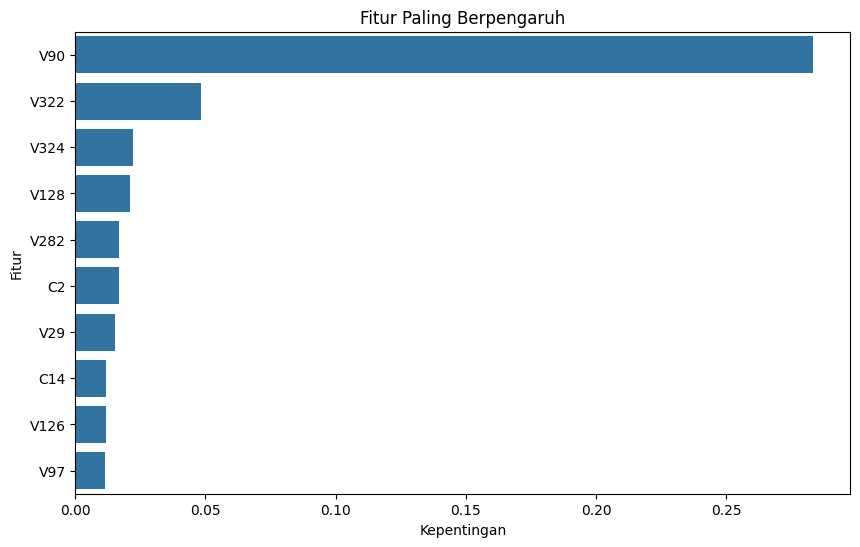

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sekarang 'sns' dan 'plt' sudah didefinisikan
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Fitur': feature_names, 'Kepentingan': importances})
feature_importance_df = feature_importance_df.sort_values(by='Kepentingan', ascending=False)

# Visualisasi 10 fitur teratas
plt.figure(figsize=(10, 6))
sns.barplot(x='Kepentingan', y='Fitur', data=feature_importance_df.head(10))
plt.title('Fitur Paling Berpengaruh')
plt.show()

In [ ]:
import joblib
# Simpan pipeline XGBoost
joblib.dump(best_model, 'fraud_model_pipeline.pkl')
# Simpan model Isolation Forest untuk anomaly_score
joblib.dump(iso_forest, 'iso_forest_model.pkl')

['iso_forest_model.pkl']

In [ ]:
import joblib

# 1. Simpan Pipeline XGBoost (sudah termasuk SMOTE dan Classifier)
joblib.dump(best_model, 'fraud_model_xgboost.pkl')

# 2. Simpan Model Isolation Forest untuk menghasilkan fitur anomaly_score
joblib.dump(iso_forest, 'iso_forest_model.pkl')

print("Model berhasil disimpan!")

Model berhasil disimpan!


In [ ]:
import joblib

# 1. Simpan Label Encoders untuk kolom kategorikal
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Pastikan fit pada data asli yang ada di notebook
    le.fit(df_sample[col].astype(str))
    encoders[col] = le

# 2. Simpan Mapping Agregat (State)
state_mapping = {
    'counts': {},
    'means': {
        'card1_mean': X_train.groupby('card1')['TransactionAmt'].mean().to_dict()
    },
    'hourly': X_train.groupby(['card1', 'Transaction_hour'])['TransactionAmt'].count().to_dict()
}

for col in ['card1', 'card2', 'card3', 'card5', 'addr1', 'P_emaildomain']:
    state_mapping['counts'][col] = X_train[col].value_counts(dropna=False).to_dict()

# 3. Export semua
joblib.dump(encoders, 'label_encoders.pkl')
joblib.dump(state_mapping, 'state_mapping.pkl')
joblib.dump(cat_cols, 'cat_cols.pkl')
joblib.dump(num_cols, 'num_cols.pkl')
# Model XGBoost dan IsoForest sudah Anda simpan sebelumnya

['num_cols.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib

class FraudInferencePipeline:
    def __init__(self):
        # Load semua model dan state yang disimpan dari notebook
        self.xgb_model = joblib.load('fraud_model_xgboost.pkl')
        self.iso_model = joblib.load('iso_forest_model.pkl')
        self.encoders = joblib.load('label_encoders.pkl')
        self.state = joblib.load('state_mapping.pkl')
        self.cat_cols = joblib.load('cat_cols.pkl')
        self.num_cols = joblib.load('num_cols.pkl')
        self.threshold = 0.3 # Sesuai optimasi di notebook

    def preprocess(self, raw_data):
        # 1. Konversi dictionary ke DataFrame 1 baris
        df = pd.DataFrame([raw_data])

        # 2. Imputasi (Sesuai logika sel 4 di notebook)
        df[self.cat_cols] = df[self.cat_cols].fillna('MISSING')
        df[self.num_cols] = df[self.num_cols].fillna(-999)

        # 3. Label Encoding
        for col in self.cat_cols:
            le = self.encoders[col]
            # Handle label baru yang tidak ada saat training
            df[col] = df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

        # 4. Feature Engineering: Time
        df['Transaction_hour'] = (df['TransactionDT'] / 3600) % 24

        # 5. Feature Engineering: Aggregates (Menggunakan state training)
        for col in ['card1', 'card2', 'card3', 'card5', 'addr1', 'P_emaildomain']:
            df[f'{col}_count'] = df[col].map(self.state['counts'][col]).fillna(0)

        df['Amt_to_mean_card1'] = df['TransactionAmt'] / df['card1'].map(self.state['means']['card1_mean']).fillna(1)

        # Multi-index mapping untuk trans_count_per_hour
        df['trans_count_per_hour'] = df.apply(
            lambda x: self.state['hourly'].get((x['card1'], x['Transaction_hour']), 0), axis=1
        )

        # 6. Anomaly Score (Unsupervised)
        # Pastikan urutan kolom sesuai dengan saat fit_predict di notebook
        df['anomaly_score'] = self.iso_model.predict(df.drop(columns=['TransactionID'], errors='ignore'))

        return df

    def predict(self, raw_data):
        # Jalankan Preprocessing
        processed_df = self.preprocess(raw_data)

        # Pastikan kolom sesuai urutan training (penting untuk XGBoost)
        # Ambil probabilitas untuk kelas 1 (Fraud)
        prob = self.xgb_model.predict_proba(processed_df)[:, 1][0]

        # Keputusan berdasarkan threshold 0.3
        prediction = 1 if prob >= self.threshold else 0

        return {
            "is_fraud": bool(prediction),
            "confidence_score": round(float(prob), 4),
            "status": "High Risk" if prediction == 1 else "Safe"
        }

# --- Contoh Penggunaan ---
# pipeline = FraudInferencePipeline()
# result = pipeline.predict(data_transaksi_baru)
# print(result)